#Standard Imports

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from PIL import Image
import os

#Create Dataset

In [29]:
class dataset(Dataset):

  def __init__(self, df, **kw):

    super(dataset, self).__init__(**kw)

    self.data = []

    for row in range(len(df)):

      data = df.iloc[row, :2]
      label = df.iloc[row, -1]

      self.data.append((torch.tensor(data, dtype=torch.float32), torch.tensor([label], dtype=torch.float32)))

  def __len__(self):

    return len(self.data)

  def __getitem__(self, idx):

    d, l = self.data[idx]

    return d, l

#Model Architecture

In [30]:
class linear_classification(Dataset, nn.Module):

  def __init__(self, input_dim):

    super(linear_classification, self).__init__()

    self.input_dim = input_dim

    self.fc = nn.Linear(self.input_dim, 1)

  def forward(self, x):

    out = self.fc(x)

    return torch.sigmoid(out)

#Build Linear Classifier

In [31]:
class My_Linear_Classification:

  def __init__(self):

    pass

  def _makeGIF_(self, duration):

    fp_in = "*_plot.png"
    fp_out = "Learning_Process.gif"

    img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]

    img.save(fp=fp_out, format='GIF', append_images=imgs,
            save_all=True, duration=duration, loop=0)
    
  def _savingRule_(self, num):

    alphabets = 'abcdefghijklmnopqrstuvwxyz'
    numbers = '0123456789'
    len_up = len(alphabets) * len(numbers)
    len_down = len(numbers)

    lft1, num = num // len_up, num % len_up

    lft2, lft3 = num // len_down, num % len_down

    name = alphabets[lft1] + alphabets[lft2] + numbers[lft3]

    return name

  def create_dataloader(self, df):

    self.df = df

    train_df = dataset(self.df)
    train_dataloader = DataLoader(train_df, batch_size=len(self.df), shuffle=False)

    return train_dataloader

  def fit(self, dataloader, epochs, verbos = False):
    
    self.losses = []
    self.whole_params = []

    self.model = linear_classification(input_dim = 2)
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(self.model.parameters(), lr = 0.01)

    self.model.train()

    for ep in range(epochs):

      for idx, (data, label) in enumerate(dataloader):

        y_pred = self.model(data)
        loss = criterion(y_pred, label)

        if verbos:

          print(f'Loss: {loss}')

        self.losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ep % 200 == 0 or ep == epochs - 1:

          params = []

          for param in self.model.parameters():

            params.append(param)

          weights = params[0][0]
          bias = params[1].item()
          w0 = weights[0].item()
          w1 = weights[1].item()

          self.whole_params.append((bias, w0, w1))

    self.params = {'w0':w0, 'w1':w1, 'b':bias}

    for i in range(len(self.whole_params)):

      epoch_th = 200 * i if i < len(self.whole_params) - 1 else epochs

      bias_, w0_, w1_ = self.whole_params[i]

      self.line = {'slope':-w0_/w1_, 'intercept':-bias_/w1_}

      line = lambda x : (-w0_/w1_)*x + (-bias_/w1_)

      self.df['y_line'] = None

      for idx in range(len(self.df)):

        self.df.iloc[idx, -1] = line(self.df.iloc[idx, 0])

      fig = plt.figure(figsize = (12, 8))
      sns.set_theme()
      sns.scatterplot(data=self.df, x=self.df.columns[0], y=self.df.columns[1], hue = self.df.columns[-2])
      sns.lineplot(data=self.df, x=self.df.columns[0], y=self.df.columns[-1], color = "green")
      plt.xlabel(self.df.columns[0])
      plt.ylabel(self.df.columns[1])
      plt.title(f"After {epoch_th} epochs")
      m = "%.2f"%(self.line['slope'])
      h = "%.2f"%(self.line['intercept'])
      plt.legend([f"Y = {m}X + {h}", 1.0, 0.0],loc = 'best')
      plt.savefig(f'{self._savingRule_(i)}_plot.png')
      plt.close(fig)

    self.df.drop(['y_line'], axis = 1, inplace = True)

    self._makeGIF_(duration = 300)

    os.system("rm -rf *_plot.png")

#Test

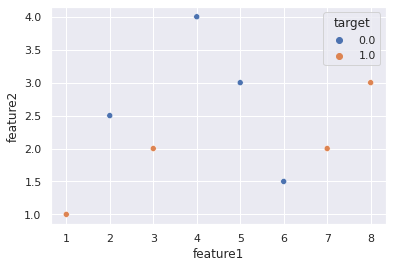

In [34]:
df = pd.DataFrame(None)

df['feature1'] = np.array([i for i in range(1, 9)])
df['feature2'] = np.array([1., 2.5, 2., 4., 3., 1.5, 2., 3])
df['target'] = np.array([1., 0., 1., 0., 0., 0., 1.0, 1.0])

plt.figure(figsize = (6, 4))
sns.set_theme()

sns.scatterplot(data=df, x=df.columns[0], y=df.columns[1], hue = df.columns[-1])

plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])

plt.show()

In [35]:
cls = My_Linear_Classification()

dataloader = cls.create_dataloader(df = df)
cls.fit(dataloader = dataloader, epochs = 17000)